# Training a Machine Learning Classifier for HP-PPI Prediction Task

Classifier: Logistic Regression
- relatively fast

In [1]:
import os
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, average_precision_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from imblearn.under_sampling import RandomUnderSampler

from IPython.display import display, Markdown

# Suppress warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning, ChangedBehaviorWarning

warnings.simplefilter('ignore', category=(UndefinedMetricWarning,
                                          ChangedBehaviorWarning,
                                          RuntimeWarning))

/home/rei/anaconda3/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [2]:
# Set up directories
SEED = 149028763
parent_dir = os.path.dirname(os.getcwd())

dir_in = os.path.join(parent_dir, 'data', 'features')
dir_out = os.path.join(parent_dir, 'data', 'results')

In [3]:
# Function for combining datasets
def get_dataset(pathogens):
    '''Combine features and labels of different pathogen datasets'''
    
    X = []
    y = []
    
    # Iterate through datasets
    for pathogen in pathogens:
        f_in = os.path.join(dir_in, '%s_features.pkl' % pathogen)
        X_, y_ = joblib.load(f_in)
        X.append(X_)
        y.append(y_)
    
    # Combine features (X) and labels (y)
    X = sparse.vstack(X)
    y = np.concatenate(y)
    
    return X, y

In [4]:
# Load all datasets
pathogens = ['Bacan', 'Yerpe', 'Fratu']
X, y = get_dataset(pathogens)
print('Loaded %i samples with %i features' % X.shape)

# Split data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify=y,
                                                    random_state=SEED)

Loaded 105822 samples with 4456 features


## Hyperparameter Tuning

Grid search with `LogisticRegressionCV`

In [5]:
# Built-in logistic regression tuning with CV
Cs = np.logspace(-2, 2, num=11)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = 'neg_log_loss'

clf = LogisticRegressionCV(Cs=Cs, penalty='l1', solver='liblinear',
                           cv=cv, scoring=scoring, max_iter=2000,
                           random_state=SEED)

_ = clf.fit(X_train, y_train)

In [6]:
# Examine model parameter
best_C = clf.C_
print('Best parameter: C = %.4f' % best_C)
print('Test %s score: %.4f' % (scoring, clf.score(X_test, y_test)))

Best parameter: C = 2.5119
Test neg_log_loss score: -0.0898


              precision    recall  f1-score   support

           0     0.9795    0.9980    0.9887     19657
           1     0.9657    0.7275    0.8298      1508

    accuracy                         0.9787     21165
   macro avg     0.9726    0.8627    0.9092     21165
weighted avg     0.9785    0.9787    0.9773     21165



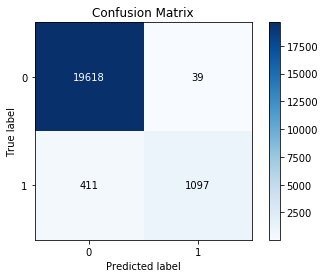

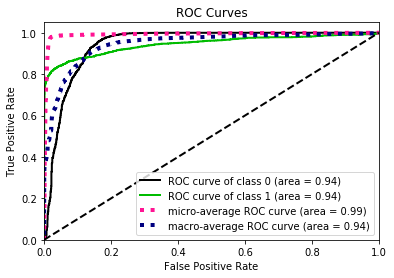

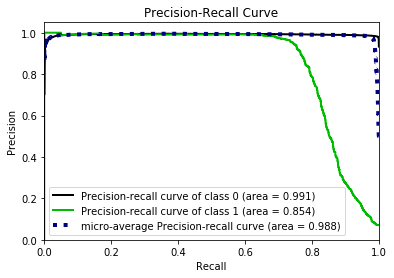

In [7]:
# Evaluate model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)

print(classification_report(y_test, y_pred, digits=4))

# Plot metrics
_ = plot_confusion_matrix(y_test, y_pred)
_ = plot_roc(y_test, y_proba)
_ = plot_precision_recall(y_test, y_proba)
_ = plt.show()

## Evaluate model on partitioned datasets

C = 2.5119
                               Test 1                                
                          Test Pathogen: Bacan
                          
              precision    recall  f1-score   support

           0     0.9757    0.9597    0.9676     36476
           1     0.5627    0.6849    0.6178      2764

    accuracy                         0.9403     39240
   macro avg     0.7692    0.8223    0.7927     39240
weighted avg     0.9466    0.9403    0.9430     39240



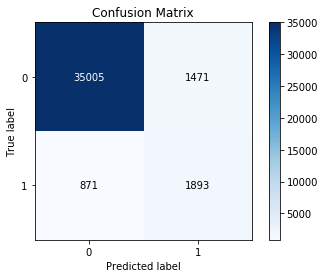

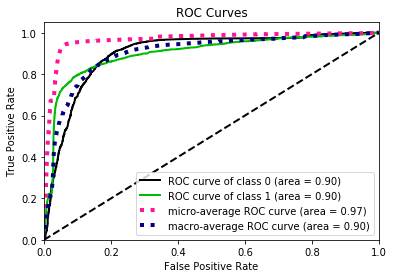

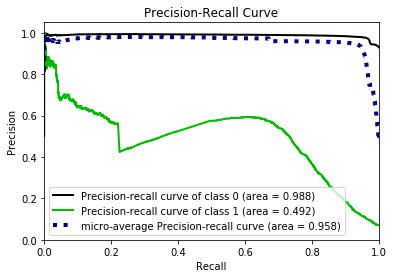

<hr></hr>

C = 2.5119
                               Test 2                                
                          Test Pathogen: Yerpe
                          
              precision    recall  f1-score   support

           0     0.9758    0.9758    0.9758     49151
           1     0.6688    0.6688    0.6688      3590

    accuracy                         0.9549     52741
   macro avg     0.8223    0.8223    0.8223     52741
weighted avg     0.9549    0.9549    0.9549     52741



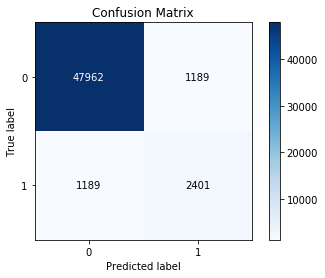

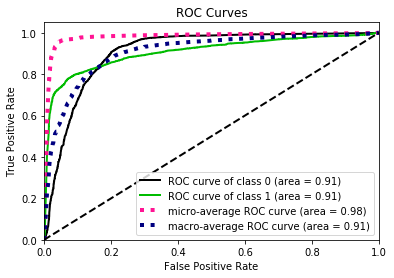

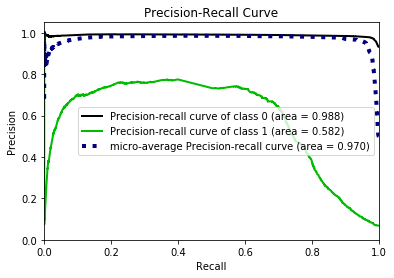

<hr></hr>

C = 2.5119
                               Test 3                                
                          Test Pathogen: Fratu
                          
              precision    recall  f1-score   support

           0     0.9764    0.9722    0.9743     12654
           1     0.7166    0.7498    0.7328      1187

    accuracy                         0.9531     13841
   macro avg     0.8465    0.8610    0.8536     13841
weighted avg     0.9541    0.9531    0.9536     13841



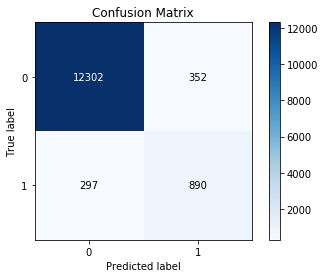

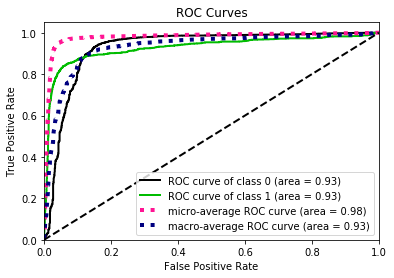

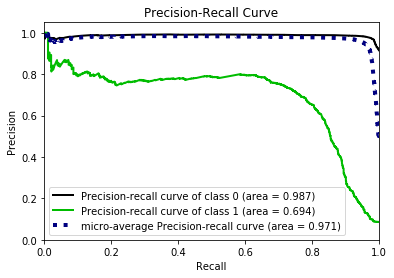

<hr></hr>

In [8]:
# Train and test classifier on different datasets
## Partition datasets by pathogen species
%matplotlib inline
i = 0 # track number of tests

for p_test in pathogens:
    p_train = [p for p in pathogens if p != p_test]
    X_train, y_train = get_dataset(p_train)
    
    # Train classifier with validation set
    _ = clf.fit(X_train, y_train)
    print('C = %.4f' % clf.C_)
    
    # Evaluate performance on test set
    X_test, y_test = get_dataset([p_test])
    y_pred = clf.predict(X_test)
    y_proba = clf.predict_proba(X_test)
    
    i += 1
    
    print('Test %i'.center(70) % i)
    print('Test Pathogen: %s\n'.center(70) % p_test)
    print(classification_report(y_test, y_pred, digits=4))
    
    # Plot metrics
    _ = plot_confusion_matrix(y_test, y_pred)
    _ = plot_roc(y_test, y_proba)
    _ = plot_precision_recall(y_test, y_proba)
    _ = plt.show()
    
    display(Markdown('<hr></hr>'))

In [9]:
# Refit model with the whole dataset
_ = clf.fit(X, y)
print('C = %.4f' % clf.C_)

# Dump model as pickle
_ = joblib.dump(clf, 'best_model.pkl')

C = 2.5119
